# Gauss-Laguerre Quadratur für die Gamma-Funktion

$$
    \Gamma(z)
    = 
    \int_0^\infty t^{z-1}e^{-t}dt
$$

$$
    \int_0^\infty f(x) e^{-x} dx 
    \approx 
    \sum_{i=1}^{N} f(x_i) w_i
    \qquad\text{ wobei }
    w_i = \frac{x_i}{(n+1)^2 [L_{n+1}(x_i)]^2}
$$
und $x_i$ sind Nullstellen des Laguerre Polynoms $L_n(x)$

Der Fehler ist gegeben als

$$
    E 
    =
    \frac{(n!)^2}{(2n)!} f^{(2n)}(\xi) 
    = 
    (-2n + z)_{2n} \frac{(n!)^2}{(2n)!} \xi^{z - 2n - 1}
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from cmath import exp, pi, sin, sqrt
import scipy.special

EPSILON = 1e-07


In [3]:
lanczos_p = [
    676.5203681218851,
    -1259.1392167224028,
    771.32342877765313,
    -176.61502916214059,
    12.507343278686905,
    -0.13857109526572012,
    9.9843695780195716e-6,
    1.5056327351493116e-7,
]


def drop_imag(z):
    if abs(z.imag) <= EPSILON:
        z = z.real
    return z


def lanczos_gamma(z):
    z = complex(z)
    if z.real < 0.5:
        y = pi / (sin(pi * z) * lanczos_gamma(1 - z))  # Reflection formula
    else:
        z -= 1
        x = 0.99999999999980993
        for (i, pval) in enumerate(lanczos_p):
            x += pval / (z + i + 1)
        t = z + len(lanczos_p) - 0.5
        y = sqrt(2 * pi) * t ** (z + 0.5) * exp(-t) * x
    return drop_imag(y)


In [4]:
zeros = np.array(
    [
        1.70279632305101000e-1,
        9.03701776799379912e-1,
        2.25108662986613069e0,
        4.26670017028765879e0,
        7.04590540239346570e0,
        1.07585160101809952e1,
        1.57406786412780046e1,
        2.28631317368892641e1,
    ]
)

weights = np.array(
    [
        3.69188589341637530e-1,
        4.18786780814342956e-1,
        1.75794986637171806e-1,
        3.33434922612156515e-2,
        2.79453623522567252e-3,
        9.07650877335821310e-5,
        8.48574671627253154e-7,
        1.04800117487151038e-9,
    ]
)


def pochhammer(z, n):
    return np.prod(z + np.arange(n))


def find_shift(z, target):
    factor = 1.0
    steps = int(np.floor(target - np.real(z)))
    zs = z + steps
    if steps > 0:
        factor = 1 / pochhammer(z, steps)
    elif steps < 0:
        factor = pochhammer(zs, -steps)
    return zs, factor


def laguerre_gamma(z, x, w, target=11):
    # res = 0.0
    z = complex(z)
    if z.real < 1e-3:
        res = pi / (
            sin(pi * z) * laguerre_gamma(1 - z, x, w, target)
        )  # Reflection formula
    else:
        z_shifted, correction_factor = find_shift(z, target)
        res = np.sum(x ** (z_shifted - 1) * w)
        res *= correction_factor
    res = drop_imag(res)
    return res


In [5]:
def eval_laguerre(x, target=12):
    return np.array([laguerre_gamma(xi, zeros, weights, target) for xi in x])


def eval_lanczos(x):
    return np.array([lanczos_gamma(xi) for xi in x])


def eval_mean_laguerre(x, targets):
    return np.mean([eval_laguerre(x, target) for target in targets], 0)


def calc_rel_error(x, y):
    return (y - x) / x


def evaluate(x, target=12):
    lanczos_gammas = eval_lanczos(x)
    laguerre_gammas = eval_laguerre(x, target)
    rel_error = calc_rel_error(lanczos_gammas, laguerre_gammas)
    return rel_error


### Test with real values

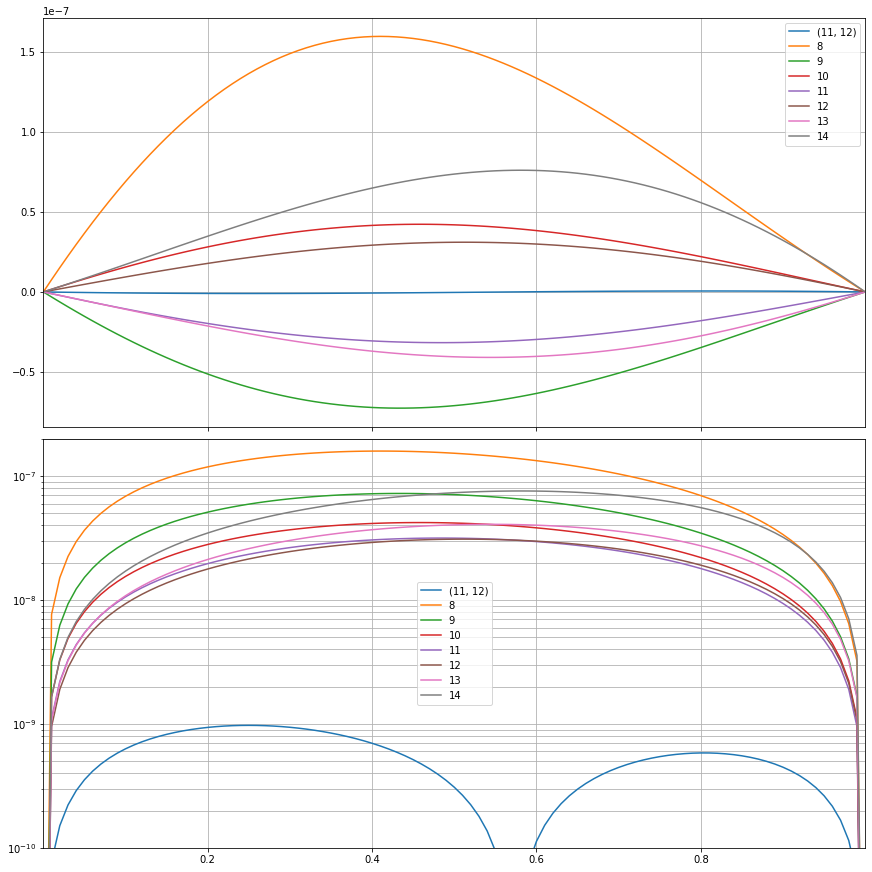

In [60]:
targets = np.arange(8, 15)
mean_targets = ((11, 12),)
x = np.linspace(EPSILON, 1 - EPSILON, 101)
_, axs = plt.subplots(
    2, sharex=True, clear=True, constrained_layout=True, figsize=(12, 12)
)

lanczos = eval_lanczos(x)
for mean_target in mean_targets:
    vals = eval_mean_laguerre(x, mean_target)
    rel_error_mean = calc_rel_error(lanczos, vals)
    axs[0].plot(x, rel_error_mean, label=mean_target)
    axs[1].semilogy(x, np.abs(rel_error_mean), label=mean_target)

for target in targets:
    rel_error = evaluate(x, target)
    axs[0].plot(x, rel_error, label=target)
    axs[1].semilogy(x, np.abs(rel_error), label=target)
# axs[0].set_ylim(*(np.array([-1, 1]) * 3.5e-8))

axs[0].set_xlim(x[0], x[-1])
axs[1].set_ylim(1e-10, 2e-7)
for ax in axs:
    ax.legend()
    ax.grid(which="both")


(-7.5, 25.0)

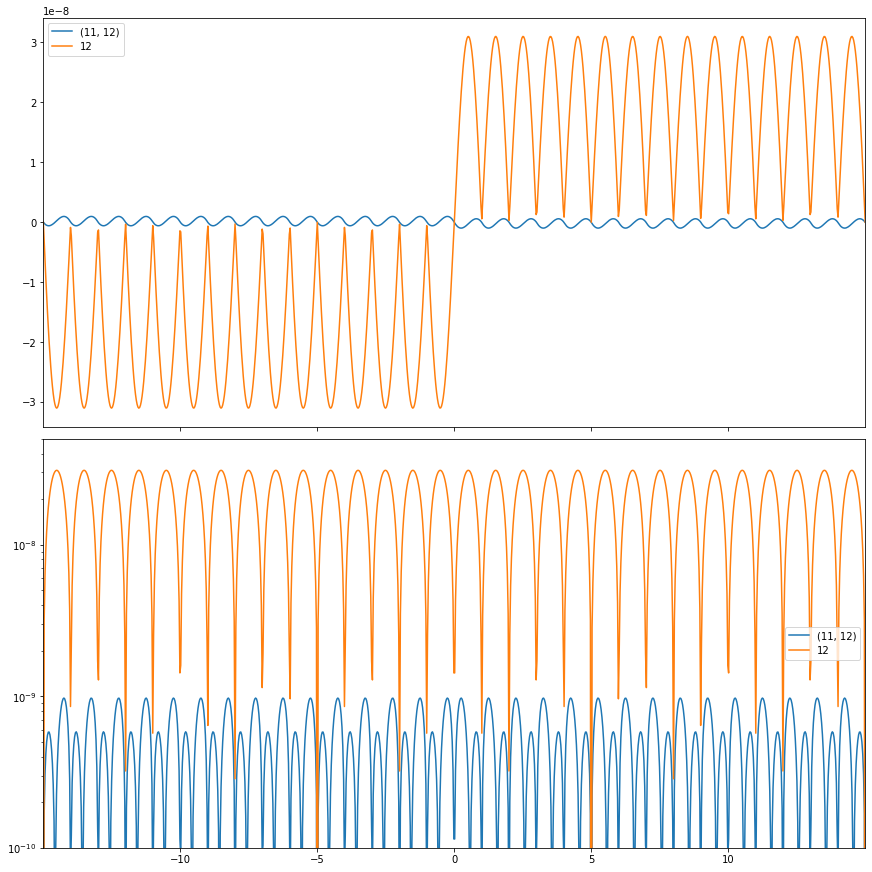

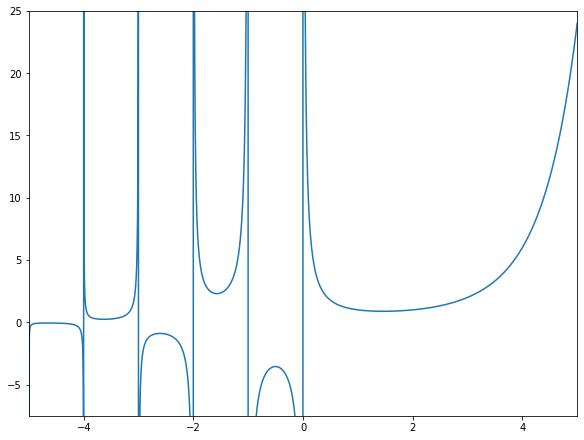

In [7]:
targets = (11, 12)
xmax = 15
x = np.linspace(-xmax + EPSILON, xmax - EPSILON, 1000)

mean_lag = eval_mean_laguerre(x, targets)
lanczos = eval_lanczos(x)
rel_error = calc_rel_error(lanczos, mean_lag)
rel_error_simple = evaluate(x, targets[-1])
# rel_error = evaluate(x, target)

_, axs = plt.subplots(
    2, sharex=True, clear=True, constrained_layout=True, figsize=(12, 12)
)
axs[0].plot(x, rel_error, label=targets)
axs[1].semilogy(x, np.abs(rel_error), label=targets)
axs[0].plot(x, rel_error_simple, label=targets[-1])
axs[1].semilogy(x, np.abs(rel_error_simple), label=targets[-1])
axs[0].set_xlim(x[0], x[-1])
# axs[0].set_ylim(*(np.array([-1, 1]) * 4.2e-8))
axs[1].set_ylim(1e-10, 5e-8)
for ax in axs:
    ax.legend()

x2 = np.linspace(-5 + EPSILON, 5, 4001)
_, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
ax.plot(x2, eval_mean_laguerre(x2, targets))
ax.set_xlim(x2[0], x2[-1])
ax.set_ylim(-7.5, 25)


### Test with complex values

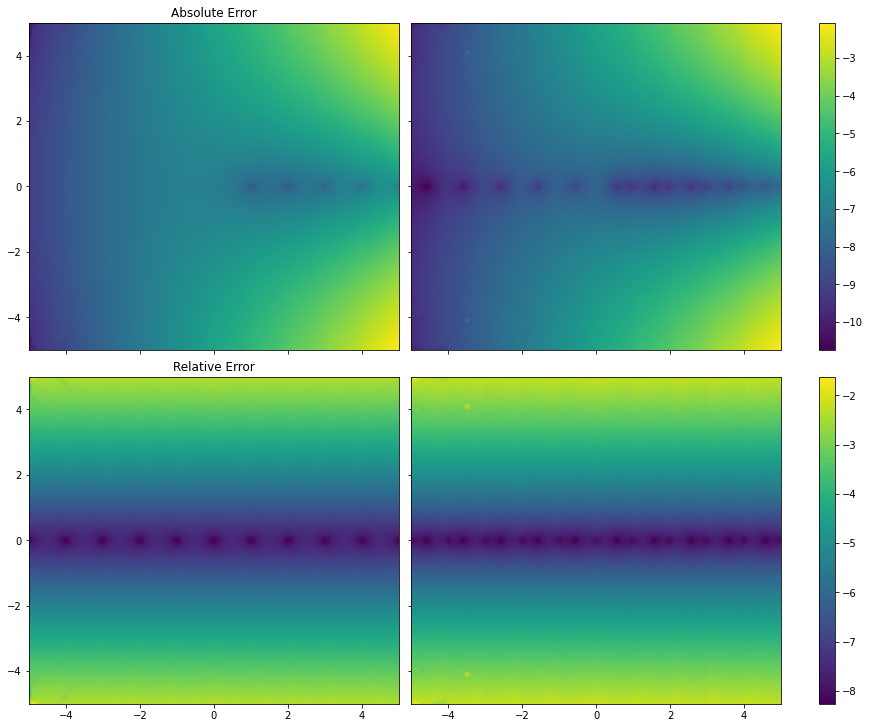

In [10]:
targets = (11, 12)
vals = np.linspace(-5 + EPSILON, 5, 100)
x, y = np.meshgrid(vals, vals)
mesh = x + 1j * y
input = mesh.flatten()

mean_lag = eval_mean_laguerre(input, targets).reshape(mesh.shape)
lanczos = eval_lanczos(input).reshape(mesh.shape)
rel_error = np.abs(calc_rel_error(lanczos, mean_lag))

lag = eval_laguerre(input, targets[-1]).reshape(mesh.shape)
rel_error_simple = np.abs(calc_rel_error(lanczos, lag))
# rel_error = evaluate(x, target)

fig, axs = plt.subplots(
    2,
    2,
    sharex=True,
    sharey=True,
    clear=True,
    constrained_layout=True,
    figsize=(12, 10),
)
_c = axs[0, 1].pcolormesh(x, y, np.log10(np.abs(lanczos - mean_lag)), shading="gouraud")
_c = axs[0, 0].pcolormesh(x, y, np.log10(np.abs(lanczos - lag)), shading="gouraud")
fig.colorbar(_c, ax=axs[0, :])
_c = axs[1, 1].pcolormesh(x, y, np.log10(rel_error), shading="gouraud")
_c = axs[1, 0].pcolormesh(x, y, np.log10(rel_error_simple), shading="gouraud")
fig.colorbar(_c, ax=axs[1, :])
_ = axs[0, 0].set_title("Absolute Error")
_ = axs[1, 0].set_title("Relative Error")


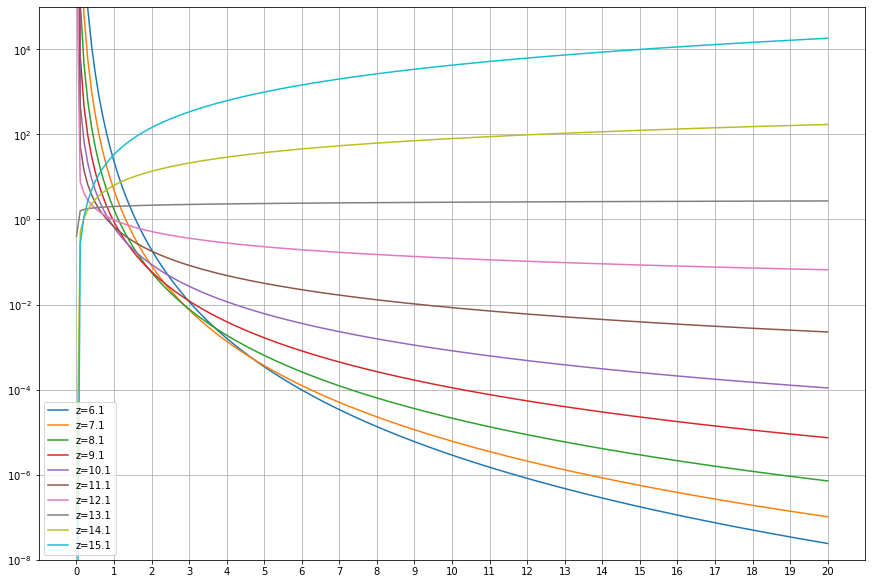

In [67]:
# TODO: Macht kei Sinn!
n = 8
ms = np.arange(4, 5)
xi = np.linspace(EPSILON, 20, 201)[:, None]
z = np.arange(6, 16)[None]+0.1
c = scipy.special.factorial(n) ** 2 / scipy.special.factorial(2 * n)


_, ax = plt.subplots(clear=True, constrained_layout=True, figsize=(12, 8))
ax.grid(1)
for m, color in zip(ms, ['r', 'b', 'g', 'c', 'm', 'y']):
    e = np.abs(
        scipy.special.poch(z - 2 * n, 2 * n)
        / scipy.special.poch(z - m, m)
        * c
        * xi ** (z - 2 * n + m - 1)
    )
    # ax.semilogy(xi, e, color=color)
    ax.semilogy(xi, e)
    ax.set_xticks(np.arange(xi[-1] +1))
    ax.set_ylim(1e-8, 1e5)
    _ = ax.legend([f'z={zi}' for zi in z[0]])
